At the end of this notebook, we will have submitted to the ["Paddy Doctor: Paddy Disease Classification" competition on Kaggle](https://www.kaggle.com/competitions/paddy-disease-classification/overview)!

Let us begin by downloading the data.

In [1]:
%%bash

exec bash
# rm -rf data
# mkdir data
apt install unzip


Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 43 not upgraded.
Need to get 168 kB of archives.
After this operation, 567 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.1 [168 kB]
Fetched 168 kB in 0s (2778 kB/s)
Selecting previously unselected package unzip.
(Reading database ... 44825 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1.1) ...
Setting up unzip (6.0-21ubuntu1.1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...




debconf: delaying package configuration, since apt-utils is not installed


In [2]:
pip install -U timm

     |████████████████████████████████| 431 kB 25.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
!cd data && kaggle competitions download -c paddy-disease-classification && unzip -q paddy-disease-classification.zip

100%|█████████████████████████████████████▉| 1.02G/1.02G [00:48<00:00, 23.6MB/s]
100%|██████████████████████████████████████| 1.02G/1.02G [00:48<00:00, 22.5MB/s]


In [1]:
import timm

We have now downloaded and extracted the data to the `data` directory.

In [2]:
ls data

paddy-disease-classification.zip  submissions/  train.csv
sample_submission.csv             test_images/  train_images/


In [3]:
ls data/train_images

bacterial_leaf_blight/     blast/       downy_mildew/  tungro/
bacterial_leaf_streak/     brown_spot/  hispa/
bacterial_panicle_blight/  dead_heart/  normal/


In [4]:
ls data/test_images | head

200001.jpg
200002.jpg
200003.jpg
200004.jpg
200005.jpg
200006.jpg
200007.jpg
200008.jpg
200009.jpg
200010.jpg
ls: write error: Broken pipe


Seems that the train data is organized by directories, with the name of the directory being the label.

Test images just live in `data/test_images`

Let us see what is the format of the sample submission file to have a full picture.

In [5]:
import pandas as pd

sample_sub = pd.read_csv('data/sample_submission.csv')
sample_sub.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


Mhmm. Guessing the labels for the submission are the names of the directories.

Ok, let's start training!

In [6]:
from fastai.vision.all import *

I am going through the `01_intro.ipynb` notebook and it seems the files in the example there are organizedin a different way than the files here 🤔

Well, but I have the handy `doc` function! I bet it can give me a suggestion on how to approach this!

I see that this `ImageDataLoaders` is used... I run `doc` on it and click `Show in docs` to read a bit more about this in my browser.

In [7]:
doc(ImageDataLoaders)

class ImageDataLoaders [source] ImageDataLoaders ( * loaders , path = '.' , device = None ) :: DataLoaders 
 
 Basic wrapper around several DataLoader s with factory methods for computer vision problems 
 Show in docs

Well, the `from_path_re` class method seems interesting. Maybe I can get it to work.

In [7]:
fns = get_image_files('data/train_images/')
fns # looks about right!

(#10407) [Path('data/train_images/bacterial_panicle_blight/109162.jpg'),Path('data/train_images/bacterial_panicle_blight/109183.jpg'),Path('data/train_images/bacterial_panicle_blight/101765.jpg'),Path('data/train_images/bacterial_panicle_blight/101592.jpg'),Path('data/train_images/bacterial_panicle_blight/104770.jpg'),Path('data/train_images/bacterial_panicle_blight/110190.jpg'),Path('data/train_images/bacterial_panicle_blight/106643.jpg'),Path('data/train_images/bacterial_panicle_blight/104269.jpg'),Path('data/train_images/bacterial_panicle_blight/108023.jpg'),Path('data/train_images/bacterial_panicle_blight/107676.jpg')...]

Now let me experiment with just a single path and a regex pattern.

In [8]:
import re

In [9]:
str(fns[0])

'data/train_images/bacterial_panicle_blight/109162.jpg'

In [10]:
pat = r'/([^/]*)/\d+.jpg$'
re.search(pat, str(fns[0])).group(1)

'bacterial_panicle_blight'

Well, this seems to work. Only way to find out is to try!

And don't worry about the regex. I copied it from the docs 😄 I don't mind writing regexes, expecially with useful [tools around](https://pythex.org/) but I always, ALWAYS have to google the API. Is it `search` or `match`? How do the groups work? Oh dear...

Anyhow

In [11]:
dls = ImageDataLoaders.from_path_re('data', fns, pat, item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros), bs=64, val_bs=64)

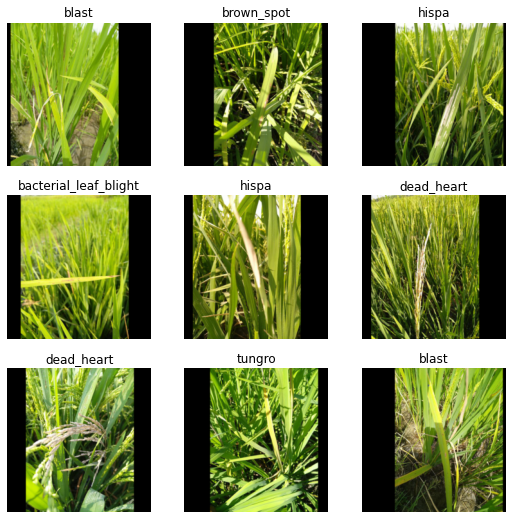

In [12]:
dls.train.show_batch()

Looks like it worked! 🥳

In [13]:
len(dls.train), len(dls.valid)

(130, 33)

In [14]:
dls.bs

64

In [15]:
dls.valid.bs

64

I am just clicking around, learning about the objects I got returned! Marvelous!

Let's train.

In [17]:
import timm

In [18]:
timm??

Type:        module
String form: <module 'timm' from '/opt/conda/lib/python3.7/site-packages/timm/__init__.py'>
File:        /opt/conda/lib/python3.7/site-packages/timm/__init__.py
Source:     
from .version import __version__
from .models import create_model, list_models, is_model, list_modules, model_entrypoint, \
    is_scriptable, is_exportable, set_scriptable, set_exportable, has_model_default_key, is_model_default_key, \
    get_model_default_value, is_model_pretrained


In [18]:
timm.list_models("vit*")

['vit_base_patch8_224',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch16_sam_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_patch32_sam_224',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_large_r50_s32_224',
 'vit_large_r50_s32_224_in21k',
 'vit_large_r50_s32_384',
 'vit_small_patch16_224',
 'vit_small_patch16_224_in21k',
 'vit_small_patch16_3

In [16]:
learn = vision_learner(dls, 'vit_base_patch16_224_in21k', metrics=error_rate)
learn.fine_tune(14, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.045192,0.718594,0.230658,01:58


epoch,train_loss,valid_loss,error_rate,time
0,0.460889,0.278002,0.094666,02:36
1,0.331506,0.267006,0.080250,02:36
2,0.319993,0.519362,0.158097,02:36
3,0.282662,0.551730,0.165305,02:36
4,0.251446,0.316672,0.092263,02:36
5,0.193052,0.333104,0.085536,02:36
6,0.142677,0.182131,0.047573,02:36
7,0.096796,0.182698,0.042768,02:36
8,0.073224,0.133534,0.031235,02:36
9,0.046696,0.132431,0.027871,02:35


Well, that seems like a surprisingly good performance given how challenging the task seems 🤔

Let's see how we can obtain predictions from our model.

In [17]:
preds = learn.get_preds()

In [18]:
preds

(TensorImage([[6.3128e-08, 3.4679e-06, 5.5859e-06,  ..., 1.0507e-06, 6.1644e-08,
          1.7484e-03],
         [8.9802e-11, 4.0537e-09, 1.2140e-08,  ..., 2.5070e-07, 1.0000e+00,
          6.7352e-10],
         [7.3816e-06, 1.6515e-06, 3.2089e-07,  ..., 8.5899e-07, 3.4290e-07,
          7.2796e-07],
         ...,
         [1.5896e-11, 2.7238e-12, 3.0788e-13,  ..., 2.5102e-10, 1.0724e-14,
          5.6699e-12],
         [3.0470e-11, 3.6313e-09, 1.3672e-09,  ..., 1.3200e-08, 8.8095e-11,
          1.3428e-09],
         [1.4303e-07, 1.6962e-05, 1.2333e-07,  ..., 5.2854e-05, 1.8225e-01,
          2.4813e-06]]),
 TensorCategory([4, 8, 6,  ..., 3, 4, 3]))

In [19]:
preds[0][0].sum(), preds[0][0].max()

(TensorImage(1.0000), TensorImage(0.9981))

Looks like preds maybe holds class probabilities and label idxs? But where do I get the labels from?!

In [20]:
learn.dls.c

10

Mhmm, that's not it.

In [21]:
doc(ImageDataLoaders)

class ImageDataLoaders [source] ImageDataLoaders ( * loaders , path = '.' , device = None ) :: DataLoaders 
 
 Basic wrapper around several DataLoader s with factory methods for computer vision problems 
 Show in docs

In [22]:
learn.dls.train_ds.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

After a bit of searching, I found where the category names are stored!

Now we need to predict on our test items!

In [23]:
test_dl = learn.dls.test_dl(get_image_files('data/test_images'))

In [24]:
test_preds = learn.get_preds(dl=test_dl)

In [25]:
sample_sub

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [26]:
get_image_files('data/test_images')

(#3469) [Path('data/test_images/200770.jpg'),Path('data/test_images/203307.jpg'),Path('data/test_images/203265.jpg'),Path('data/test_images/201796.jpg'),Path('data/test_images/202973.jpg'),Path('data/test_images/201780.jpg'),Path('data/test_images/201052.jpg'),Path('data/test_images/201179.jpg'),Path('data/test_images/201783.jpg'),Path('data/test_images/200080.jpg')...]

In [27]:
predicted_classes = [learn.dls.train_ds.vocab[i] for i in test_preds[0].argmax(1)]

In [28]:
predicted_classes[:10]

['bacterial_leaf_streak',
 'blast',
 'dead_heart',
 'bacterial_leaf_blight',
 'downy_mildew',
 'hispa',
 'brown_spot',
 'tungro',
 'normal',
 'dead_heart']

And the last thing we need to output predictions are file names.

In [29]:
fns = [p.name for p in get_image_files('data/test_images')]

In [30]:
sub = pd.DataFrame(data={'image_id': fns, 'label': predicted_classes})

In [ ]:
# mkdir data/submissions

In [31]:
sub.to_csv('data/submissions/brismith_sub2_vit.csv.gz', index=False)

In [32]:
!kaggle competitions submit -c paddy-disease-classification -f data/submissions/brismith_sub1.csv.gz -m "2nd sub vit walkthru11"

Traceback (most recent call last):
  File "/root/.local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/root/.local/lib/python3.7/site-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/root/.local/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 562, in competition_submit_cli
    competition, quiet)
  File "/root/.local/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 513, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/opt/conda/lib/python3.7/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'data/submissions/brismith_sub1.csv.gz'


In [33]:
!kaggle competitions submit -c paddy-disease-classification -f data/submissions/brismith_sub2_vit.csv.gz -m "2nd sub vit walkthru11"

100%|██████████████████████████████████████| 11.7k/11.7k [00:00<00:00, 24.9kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification